In [1]:
# -
#
# SPDX-FileCopyrightText: Copyright (c) 2024 Pietro Carlo Boldini, Rene Pecnik and the CUBENS contributors. All rights reserved.
# SPDX-License-Identifier: MIT
#
# -

import math as m
import cmath as cm
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
from numpy import linalg as npla

from scipy.sparse.linalg import spsolve
from scipy.sparse        import diags, hstack, vstack
from scipy.integrate     import solve_bvp


from functools import partial
import CoolProp.CoolProp as CP

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rcParams['figure.figsize']   = [8,6]
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family']      = 'STIXGeneral'

rcParams.update({'xtick.major.size': 6,  'xtick.minor.size': 4, 
                 'ytick.major.size': 6,  'ytick.minor.size': 4, 
                 'xtick.major.width': 1, 'xtick.minor.width': 1, 
                 'ytick.major.width': 1, 'ytick.minor.width': 1, 
                 'xtick.direction': 'out', 'ytick.direction': 'out',
                 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 14})

# Compressible self-similar solution for BLs

$$\frac{d}{d\eta}\left( C\frac{d^2f}{d\eta^2}\right) + f\frac{d^2f}{d\eta^2}=0$$
$$\frac{d}{d\eta}\left( \frac{C}{Pr}\frac{d g}{d\eta}\right) + f\frac{d g}{d\eta} + C \frac{u^2_\infty}{h_\infty}\left( \frac{d^2 f}{d\eta^2}\right)^2=0$$
with
$$ \frac{df}{d\eta} = \frac{u}{u_\infty}, \quad g = \frac{h}{h_\infty}$$
and
$$C=\frac{\rho\mu}{\rho_\infty \mu_\infty}, \quad Pr=\frac{\mu c_p}{k}, \quad Ec=\frac{u^2_\infty}{c_{p,\infty}T_\infty}$$

# Boundary layer scaling

Local Reynolds number:
$$Re_{\delta} = \frac{\rho_{\infty} U_{\infty} \delta}{\mu_{\infty}} = \sqrt{Re_{x}} = \sqrt{\frac{\rho_{\infty} U_{\infty} x}{\mu_{\infty}}}$$

Reynolds number in the DNS:
$$Re_{\delta_{99}} = Re_{\delta} \delta/\delta_{99} $$

Wall-normal velocity:
$$ v Re_{\delta}= \left(\frac{u \eta}{\sqrt{4.0}} - \frac{f}{\rho\sqrt{2}}\right) $$

# Boundary-layer solver

### first the definition of the functions
### to calculate, go to the last section

In [2]:
def cBL_RHS(y, f, f_pr, f_rh_T, f_muka, f_cp, intp_h_T, intp_h_rh, param, Ec, visc):
    [Ec_inf, Rhored_inf, Tred_inf, CpR_inf, CvR_inf, Pr_inf, mu_inf, ka_inf, u_inf2h_inf]= param()
    T = np.zeros(len(f[3])) 
    rh = np.zeros(len(f[3]))  
    for i, h in enumerate(f[3]):
        T0 = intp_h_T(h)
        rh0 = intp_h_rh(h)
        x    = opt.fsolve(f_rh_T, [T0,rh0],args=(h))
        T[i]= x[0]
        rh[i]= x[1] 
    CpR = f_cp(rh, T, CvR_inf) 
    [mu,ka] = f_muka(rh,T,visc)
    mu = mu / mu_inf; ka = ka / ka_inf
    rh = rh / Rhored_inf; T = T / Tred_inf 
    Pr = CpR*mu/ka*Pr_inf/CpR_inf
    C1 = rh*mu
    RHS = np.vstack(( f[1],                                            # f[0] = F0
                      f[2]/C1,                                         # f[1] = F1 = U
                     -f[0]*f[2]/C1,                                    # f[2] = F2
                      f[4]*Pr/C1,                                      # f[3] = G0 = H
                     -f[0]*f[4]*Pr/C1-u_inf2h_inf/C1*f[2]**2,          # f[4] = G1
                      np.sqrt(2.0)/rh))                                # f[5] = eta
    return RHS

def cBL_BC(f0,finf, BC_wall):
    if BC_wall == None:
        bc_res_G0 = f0[4]          # zero enthalpy gradient at the wall
    else:
        bc_res_G0 = f0[3]-BC_wall  # set enthalpy at the wall
        
    BC_res = np.array([ f0[0],
                        f0[1],
                        bc_res_G0,
                        f0[5],
                        finf[1]-1,
                        finf[3]-1 ])
    return BC_res

def solveSelfSimilar(f_pr, f_rh_T, f_muka, f_cp, intp_h_T, intp_h_rh, param, Ec, visc, BC_wall, 
                     eta=None, f=None, verbose=2, max_nodes=50000, tol=1e-30, bc_tol=1e-20): # change "verbose" for comments on iteration procedure
    # adapt max_nodes if max residual still too high
    
    # allocate eta and f and set initial condition for f
    if np.all(eta) == None and np.all(f) == None:
        N = 5000 # adapt if needed
        ymax = 10 # adapt if needed
        yi = 3 # adapt if needed
        a = ymax * yi / (ymax - 2.0 * yi)
        b = 1 + 2.0 * a / ymax
        z = -np.cos(np.linspace(0, np.pi, N))
        eta = np.zeros(N)
        for ii in range(N):
            eta[ii] = a * (1 + z[ii]) / (b - z[ii])
        f    = np.zeros((6,eta.size))
        f[1] = np.sqrt(eta/eta[-1])
        f[3] = 0.5 * (1 - eta / eta[-1])
        if BC_wall == None:
            f[3] = 1.0           
        else:
            f[3] = BC_wall + (1 - BC_wall) * (eta / eta[-1])
        f[4] = 0.0
        f[5] = eta[-1]

    # solve bvp 
    res = solve_bvp(fun = lambda y,f: cBL_RHS(y,f, f_pr, f_rh_T, f_muka, f_cp, intp_h_T, intp_h_rh, param, Ec, visc), 
                    bc  = lambda f0, finf: cBL_BC(f0, finf, BC_wall=BC_wall), 
                    x=eta, y=f, 
                    verbose=verbose, max_nodes=max_nodes, tol=tol, bc_tol=bc_tol)
    return res.sol(eta), eta

# Main class for BL calculation

In [3]:
class BL():
    def solveBL(self, f_pr, f_rh_T, f_muka, f_cp, intp_h_T, intp_h_rh, param, Ec, visc, Hw_Hinf, eta=None, f=None, tol=1.0e-13):
        
        self.f, self.eta = solveSelfSimilar(f_pr, f_rh_T, f_muka, f_cp, intp_h_T, intp_h_rh, param, Ec, visc, Hw_Hinf, eta=eta, f=f, tol=tol)
        [Ec_inf, Rhored_inf, Tred_inf, CpR_inf, CvR_inf, Pr_inf, mu_inf, ka_inf, u_inf2h_inf]= param()
        self.H   = self.f[3]
        self.U   = self.f[1]
        self.d99 = self.f[5][np.where(self.U > 0.99)[0][0]]
        self.y   = self.f[5]/self.d99
        self.T = np.zeros(len(self.f[3])) 
        self.r = np.zeros(len(self.f[3]))  
        for i, h in enumerate(self.f[3]):
            T0 = intp_h_T(h)
            rh0 = intp_h_rh(h)
            x    = opt.fsolve(f_rh_T, [T0,rh0],args=(h))
            self.T[i]= x[0]
            self.r[i]= x[1] 
        [self.mu,self.ka] = f_muka(self.r,self.T,visc)
        self.T = self.T / Tred_inf
        self.r = self.r / Rhored_inf
        self.mu = self.mu / mu_inf
        self.ka = self.ka / ka_inf
        self.V  = self.U*self.f[5]/(4.0**0.5) - self.f[0]/(self.r*2**0.5)

    def plot(self, ax, style = None, label = " "):    
        ylim = 1.5
        ax[0].plot(self.U,self.y,linestyle=style,label=label, lw=2)
        ax[0].set_title('$u$', pad = 12)
        ax[0].set_ylabel('$y_{DNS}$')
        ax[0].legend();  ax[0].set_ylim(0, ylim)

        ax[1].plot(self.T,self.y,linestyle=style,label=label, lw=2)
        ax[1].set_title('$T$', pad = 12)
        ax[1].set_ylim(0, ylim)

        ax[2].plot(self.r,self.y,linestyle=style,label=label, lw=2)
        ax[2].set_title(r'$\rho$', pad = 12)
        ax[2].set_ylim(0, ylim)

        ax[3].plot(self.V,self.y,linestyle=style,label=label, lw=2)
        ax[3].set_title(r'$v \times Re_{\delta}$', pad = 12)
        ax[3].set_ylim(0, ylim)
        
    def extendProfileToLargerYforDNS(self, ymax=None):
        yextend = np.arange(2*self.y[-1]-self.y[-2], ymax, 1e-3)
        self.y_DNS = np.concatenate((self.y, yextend))
        self.r_DNS = np.concatenate((self.r, self.r[-1]*np.ones(yextend.size)))
        self.u_DNS = np.concatenate((self.U, self.U[-1]*np.ones(yextend.size)))
        self.v_DNS = np.concatenate((self.V, self.V[-1]*np.ones(yextend.size)))
        
    def writeToFile(self):
        self.y_DNS[0] = 0.0
        self.y_DNS.tofile('inputDNS/prof_x.bin')
        self.r_DNS.tofile('inputDNS/prof_r.bin')
        self.u_DNS.tofile('inputDNS/prof_w.bin')
        self.v_DNS.tofile('inputDNS/prof_u.bin')
        file = open("inputDNS/initBL_params.h", "w")
        file.write("!------------ use equation of state ------------------ \n")
        file.write('USE_EOS  = "PR" \n')
        file.write("!------------ set non-dimensional free-stream values for computation ------------------ \n")
        file.write("delta99   = %.10f \n" % self.d99)
        file.write("Pra   = %.10f \n" % self.Pr)
        file.write("Ec   = %.10e \n" % self.Ec)
        file.write("Ma   = %.10e \n" % self.Ma)
        file.write("eos_dof   = %.6f \n" % self.dof)
        file.write("eos_ac   = %.6f \n" % self.omega_ac)
        file.write("!------------ set dimensional free-stream values for computation ------------------ \n")
        file.write("Tcrit   = %.6f \n" % self.T_crit)
        file.write("Pcrit   = %.6f \n" % self.P_crit)
        file.write("Vcrit   = %.6e \n" % self.V_crit)
        file.write("eos_Rgas   = %.6f \n" % self.Rg)
        file.write("! ------------ set wall BC for computation ------------------ \n")
        file.write('wall_bc  = "%s" \n' % self.wall_bc)
        file.write("Twall_bot   = %.6f \n" % self.Twall)
        file.write("!------------ set reference free-stream values for computation ------------------ \n")
        file.write("Tref   = %.10f \n" % self.Tred)
        file.write("Pref   = %.10f \n" % self.Pred)
        file.write("Rhoref   = %.10f \n" % self.Rhored)
        file.write("Cpref   = %.10f \n" % self.CpR)
        file.write("SOSref   = %.10f \n" % self.sos) 
        file.write("Rref   = %.10f \n" % self.R) 
        file.write("! ----------- set viscosity and conductivity ---------------- \n")
        file.write('USE_VISC  = "%s" \n' % self.visc_bc)
        if ((self.visc_bc == 'JST') or (self.visc_bc == 'Chung')):
            file.write("Muref   = %.10e \n" % self.mu_inf)
            file.write("Kref   = %.10e \n" % self.ka_inf)
        file.close()
        
    def showParameters(self):
        print("\nDNS parameters:\n")
        print("USE_EOS = PR ")
        print("delta99 = ", self.d99)
        print("Pra = ", self.Pr)
        print("Ec = ", self.Ec)
        print("Ma = ", self.Ma)
        print("Pref = ", self.Pred)
        print("Cv/R= = ", self.CvR)
        print('USE_VISC  = ', self.visc_bc)
        print('wall_bc  = ', self.wall_bc)
        
        print('\nDNS initial conditions are saved in ./inputDNS/')
        print('DNS parameters are saved in ./inputDNS/')

# Different EoS

## Peng-Robinson

In [4]:
class BL_PR(BL): 
    def __init__(self, Ec = None, Pred =None, Tred =None, CvR=None, visc = None, Pr=None, Tw_Tinf = None, eta=None, f=None):   
        self.Ec = Ec       
        self.Pred = Pred
        self.Tred = Tred 
        self.CvR = CvR
        self.f_pr()
        rho0 = CP.PropsSI("D", "P", Pred*self.P_crit, "T", Tred*self.T_crit, self.fluid)/self.Rho_crit # this is just an approximation
        self.Rhored = float(opt.fsolve(self.f_rh,rho0,args=(Tred)))
        self.Hred = self.f_h(self.Rhored, self.Tred)
        self.CpR = self.f_cp(self.Rhored, self.Tred, self.CvR) 
        self.sos = self.f_sos(self.Rhored, self.Tred, self.CvR)
        self.Ma=(self.Ec*self.CpR*self.Tred/self.sos**2/self.Zc)**0.5
        self.dof = 9  
        if Tw_Tinf == None:
            self.wall_bc = 'adiab'
            self.Twall = -1.0
            self.Hw_Hinf = None
        else:
            self.wall_bc = 'isoth'
            self.Twall = Tw_Tinf
            self.Tred_wall = Tw_Tinf*Tred
            rho0 = CP.PropsSI("D", "P", Pred*self.P_crit, "T", self.Tred_wall*self.T_crit, self.fluid)/self.Rho_crit # this is just an approximation
            self.Rhored_wall = float(opt.fsolve(self.f_rh,rho0,args=(self.Tred_wall)))
            self.Hred_wall = self.f_h(self.Rhored_wall, self.Tred_wall)
            self.Hw_Hinf = self.Hred_wall/self.Hred
        if visc == 'Constant':
            self.visc_bc = 'Constant'
            self.mu_inf = 1.0
            self.ka_inf = 1.0
            self.Pr = Pr
        elif visc == 'JST':
            self.visc_bc = 'JST'
            [self.mu_inf,self.ka_inf] = self.f_muka(self.Rhored, self.Tred, visc)
            self.Pr = Pr
        elif visc == 'Chung':
            self.visc_bc = 'Chung'
            [self.mu_inf,self.ka_inf] = self.f_muka(self.Rhored, self.Tred, visc)
            self.Pr=self.CpR*self.mu_inf/self.ka_inf*self.Rg
        # save free-stream parameters in one
        self.param()
            
        # create table for approximation
        n_values = 10000
        h_values  = np.linspace(0.5, 25, n_values) # with respect to Hred
        x0 = [self.Tred,self.Rhored]
        h_rh_T = np.zeros((len(h_values), 3))
        for i, h in enumerate(h_values):
            h0 = opt.fsolve(self.f_rh_T, x0, args=(h))
            x0 = h0
            h_rh_T[i,0]= h
            h_rh_T[i,1]= h0[0]
            h_rh_T[i,2]= h0[1]   
        print('An interpolation table is created between Tred = %.3f and %.3f with %i interpolation points' % (h_rh_T[0, 1], h_rh_T[-1, 1], n_values))
        self.intp_h_T = interp1d(h_rh_T[:,0], h_rh_T[:,1], kind='cubic', fill_value="extrapolate")
        self.intp_h_rh = interp1d(h_rh_T[:,0], h_rh_T[:,2], kind='cubic', fill_value="extrapolate")    
               
        self.solveBL(self.f_pr, self.f_rh_T, self.f_muka, self.f_cp, self.intp_h_T, self.intp_h_rh, self.param, Ec, visc, self.Hw_Hinf, eta=eta, f=f)
    
    def f_pr(self):
        self.Zc=0.3112
        self.Zc_1=self.Zc**(-1)
        self.Zc_2=self.Zc**(-2)
        self.R=1/self.Zc
        self.a=0.45724
        self.b=0.07780
        self.Ru=8.31451
        self.fluid="CO2"
        self.omega_ac=0.224
        self.K=0.37464+1.54226*self.omega_ac-0.26992*self.omega_ac**2
        self.dof=9
        self.M=CP.PropsSI("molemass",self.fluid)
        self.Rg=self.Ru/self.M         
        self.T_crit=CP.PropsSI("Tcrit",self.fluid)
        self.P_crit=CP.PropsSI("Pcrit",self.fluid)
        self.Zc_RP=0.274586376 # exact Zc according to tables for the transport properties
        self.V_crit=self.Zc_RP*self.Rg*self.T_crit/self.P_crit
        self.Rho_crit=1/self.V_crit
        return self
    
    def f_chung(self):
        self.A_chung = 1.16145
        self.B_chung = 0.14874
        self.C_chung = 0.52487
        self.D_chung = 0.77320
        self.E_chung = 2.16178
        self.F_chung = 2.43787
        self.G_chung = -6.435 * 10**(-4)
        self.H_chung = 7.27371
        self.S_chung = 18.0323
        self.W_chung = -0.76830
        self.Fc = 1 - 0.2756 * self.omega_ac  # only for non-polar
        a0 = [6.32402, 0.0012102, 5.28346, 6.62263, 19.7454, -1.89992, 24.2745, 0.79716, -0.23816, 0.068629]
        a1 = [50.4119, -0.0011536, 254.209, 38.0957, 7.63034, -12.5367, 3.44945, 1.11764, 0.067695, 0.34793]
        self.Arho = [a0[i] + a1[i] * self.omega_ac for i in range(len(a0))]
        b0 = [2.41657, -0.50924, 6.61069, 14.54250, 0.79274, -5.86340, 81.171]
        b1 = [0.74824, -1.50936, 5.62073, -8.91387, 0.82019, 12.80050, 114.158]
        self.Brho = [b0[i] + b1[i] * self.omega_ac for i in range(len(b0))]
        self.alpha = self.dof / 2 - 3 / 2
        self.beta = 0.7862 - 0.7109 * self.omega_ac + 1.3168 * self.omega_ac**2  # only for non-polar
        return self
    
    def param(self):
        Ec_inf = self.Ec
        Pred_inf=self.Pred
        Tred_inf = self.Tred
        Rhored_inf = self.Rhored
        Hred_inf = self.Hred
        CpR_inf = self.CpR
        CvR_inf = self.CvR
        sos_inf = self.sos
        Ma_inf = self.Ma
        Pr_inf = self.Pr
        mu_inf = self.mu_inf
        ka_inf = self.ka_inf
        u_inf2h_inf = Ec_inf*CpR_inf*Tred_inf/Hred_inf/self.Zc
        return Ec_inf, Rhored_inf, Tred_inf, CpR_inf, CvR_inf, Pr_inf, mu_inf, ka_inf, u_inf2h_inf
        
    def f_rh_T(self, x, h):
        T, rho = x
        F1 = T * self.Zc_1 / ((1/rho) - self.b * self.Zc_1) - self.a * ((1 + self.K * (1 - np.sqrt(T)))**2) * self.Zc_2 / ((1/rho) * ((1/rho) + 2 * self.b * self.Zc_1) - self.b**2 * self.Zc_2) - self.Pred
        F2 = (self.CvR * T * self.Zc_1 +
              self.a * self.Zc_1 / (2 * m.sqrt(2) * self.b) * ((self.K + 1)**2 - self.K * (self.K + 1) * np.sqrt(T)) *
              np.log((1 + self.b * self.Zc_1 / (1/rho) * (1 - m.sqrt(2))) / (1 + self.b * self.Zc_1 / (1/rho) * (1 + m.sqrt(2)))) +
              self.Pred * (1/rho) - h * self.Hred) 
        return np.array([F1, F2])
    
    def f_rh(self, rho, T):
        v = 1/rho
        alpha = (1 + self.K * (1 - np.sqrt(T)))**2
        Vol = T * self.Zc_1 / (v - self.b * self.Zc_1) - alpha * self.a * self.Zc_2 / (v * (v + 2 * self.b * self.Zc_1) - self.b**2 * self.Zc_2) - self.Pred
        return np.array(Vol)
    
    def f_h(self, rho, T):
        self.f_cp(rho, T, self.CvR)
        e_PR = self.CvR * T * self.Zc_1 + self.a * self.Zc_1 / (2 * m.sqrt(2) * self.b) * ((self.K + 1)**2 - self.K * (self.K + 1) * np.sqrt(T)) * np.log((1 + self.b * self.Zc_1 * rho * (1 - m.sqrt(2))) / (1 + self.b * self.Zc_1 * rho * (1 + m.sqrt(2))))
        return e_PR + self.Pred / rho
    
    def f_cp(self, rho, T, CvR):
        alpha = (1 + self.K * (1 - np.sqrt(T)))**2
        Cv_rho = self.CvR - (self.a * self.K * (self.K + 1)) / (4 * self.b * np.sqrt(2 * T)) * np.log((1 + self.b * self.Zc_1 * rho * (1 - m.sqrt(2))) / (1 + self.b * self.Zc_1 * rho * (1 + m.sqrt(2))))
        dPdT_Rho = self.K * np.sqrt(alpha / T) * (rho**2 * self.a * self.Zc_2) / (1 + 2 * self.b * self.Zc_1 * rho - self.b**2 * self.Zc_2 * rho**2) - (rho * self.Zc_1) / (rho * self.b * self.Zc_1 - 1)
        dPdRho_T = self.Zc_1 * T / (self.Zc_1 * self.b * rho - 1)**2 - self.a * self.Zc_2 * alpha * (2 * rho + 2 * self.b * self.Zc_1 * rho**2) / (1 + 2 * self.b * self.Zc_1 * rho - rho**2 * self.b**2 * self.Zc_2)**2
        return np.array(Cv_rho + T / rho**2 * self.Zc * (dPdT_Rho**2) / dPdRho_T)
    
    def f_sos(self, rho, T, CvR):
        alpha = (1 + self.K * (1 - np.sqrt(T)))**2
        Cv_rho = self.CvR - (self.a * self.K * (self.K + 1)) / (4 * self.b * np.sqrt(2 * T)) * np.log((1 + self.b * self.Zc_1 * rho * (1 - m.sqrt(2))) / (1 + self.b * self.Zc_1 * rho * (1 + m.sqrt(2))))
        dPdT_Rho = self.K * np.sqrt(alpha / T) * (rho**2 * self.a * self.Zc_2) / (1 + 2 * self.b * self.Zc_1 * rho - self.b**2 * self.Zc_2 * rho**2) - (rho * self.Zc_1) / (rho * self.b * self.Zc_1 - 1)
        dPdRho_T = self.Zc_1 * T / (self.Zc_1 * self.b * rho - 1)**2 - self.a * self.Zc_2 * alpha * (2 * rho + 2 * self.b * self.Zc_1 * rho**2) / (1 + 2 * self.b * self.Zc_1 * rho - rho**2 * self.b**2 * self.Zc_2)**2
        return (dPdRho_T + self.Zc * T / rho**2 / Cv_rho * dPdT_Rho**2)**0.5

    def f_muka(self, rho, T, visc):
        if visc == 'Constant':
            return np.maximum(T,1.0e-6)/np.maximum(T,1.0e-6), np.maximum(T,1.0e-6)/np.maximum(T,1.0e-6)
        elif visc == 'JST':
            # viscosity
            mu_1 = np.where(T <= 1.50,
                            34 * 10**(-5) * T**0.94,
                            17.78 * 10**(-5) * (4.58 * T - 1.67)**(5/8))
            f_rho = 0.10230 + 0.023364 * rho + 0.058533 * rho**2 - 0.040758 * rho**3 + 0.0093324 * rho**4
            mu_diff = (f_rho**4 - 10**(-4))
            # conductivity
            kappa_factor=(0.307*self.CvR+0.539)
            kappa_EU = 15 / 4 * self.Ru * mu_1 * kappa_factor
            kappa_RT_tri = 6.54 * 10**(-5) * (np.exp(0.2826 * T) - 1 / np.exp(0.3976 * T**2))
            kappa = np.zeros_like(rho)
            mask1 = rho < 0.50
            mask2 = (rho >= 0.50) & (rho < 2.0)
            mask3 = rho >= 2.0
            f_rho1 = 14.0 * (np.exp(0.535 * rho) - 1)
            kappa_diff1 = (f_rho1 * 10**(-8)) / self.Zc**5
            kappa[mask1] = kappa_diff1[mask1] * (4.1868 / 10**(-2)) + kappa_EU[mask1]
            f_rho2 = 13.1 * (np.exp(0.67 * rho) - 1.069)
            kappa_diff2 = (f_rho2 * 10**(-8)) / self.Zc**5
            kappa[mask2] = kappa_diff2[mask2] * (4.1868 / 10**(-2)) + kappa_EU[mask2]
            f_rho3 = 2.976 * (np.exp(1.155 * rho) + 2.016)
            kappa_diff3 = (f_rho3 * 10**(-8)) / self.Zc**5
            kappa[mask3] = kappa_diff3[mask3] * (4.1868 / 10**(-2)) + kappa_EU[mask3]
            return mu_diff + mu_1, kappa
        elif visc == 'Chung':
            self.f_chung()
            T_dim = T*self.T_crit
            # viscosity
            V_crit = self.V_crit * self.M * 10**6
            ek = self.T_crit / 1.2593
            T_dimless = T_dim / ek
            psi = (self.A_chung / T_dimless**self.B_chung) + (self.C_chung / np.exp(self.D_chung * T_dimless)) + (self.E_chung / np.exp(self.F_chung * T_dimless)) + (self.G_chung * T_dimless**self.B_chung * np.sin(self.S_chung * T_dimless**self.W_chung - self.H_chung))
            mu_0 = 4.0785 * 10**(-6) * self.Fc * (self.M * 10**3 * T_dim)**0.5 / (V_crit**(2/3) * psi)  # new version
            Y = rho * self.Zc_RP / self.Zc / 6
            G1 = (1 - 0.5 * Y) / (1 - Y)**3
            G2 = (self.Arho[0] * (1 - np.exp(-self.Arho[3] * Y)) / Y + self.Arho[1] * G1 * np.exp(self.Arho[4] * Y) + self.Arho[2] * G1) / (self.Arho[0] * self.Arho[3] + self.Arho[1] + self.Arho[2])
            mu_k = mu_0 * (1 / G2 + self.Arho[5] * Y)
            mu_p = 3.6344 * 10**(-6) * (self.M * 10**3 * self.T_crit)**0.5 / (V_crit**(2/3)) * (self.Arho[6] * Y**2 * G2 * np.exp(self.Arho[7] + self.Arho[8] * T_dimless**(-1) + self.Arho[9] * T_dimless**(-2)))
            # conductivity
            Z = 2.0 + 10.5 * T**2
            Psi = 1 + self.alpha * (0.215 + 0.28288 * self.alpha - 1.061 * self.beta + 0.26665 * Z) / (0.6366 + self.beta * Z + 1.061 * self.alpha * self.beta)
            kappa_0 = 31.2 * (mu_0 / self.M) * Psi
            H2 = (self.Brho[0] * (1 - np.exp(-self.Brho[3] * Y)) / Y + self.Brho[1] * G1 * np.exp(self.Brho[4] * Y) + self.Brho[2] * G1) / (self.Brho[0] * self.Brho[3] + self.Brho[1] + self.Brho[2])
            kappa_k = kappa_0 * (1 / H2 + self.Brho[5] * Y)
            kappa_p = 3.586 * 10**(-3) * (self.T_crit / self.M)**0.5 / (V_crit**(2/3)) * (self.Brho[6] * Y**2 * H2 * T**(0.5))
            return mu_k + mu_p, kappa_k + kappa_p         
    
    def h_interp_T(self, h):
        return self.intp_h_T(h)
    
    def h_interp_rh(self, h):
        return self.intp_h_rh(h)
    

# Solve boundary layer with Peng-Robinson fluid

An interpolation table is created between Tred = 0.912 and 1.283 with 10000 interpolation points
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  


/var/folders/5p/rrngyj517hn4884fjc0d4fsr0000gn/T/ipykernel_16455/2410331063.py:121: RuntimeWarning: invalid value encountered in sqrt
  F1 = T * self.Zc_1 / ((1/rho) - self.b * self.Zc_1) - self.a * ((1 + self.K * (1 - np.sqrt(T)))**2) * self.Zc_2 / ((1/rho) * ((1/rho) + 2 * self.b * self.Zc_1) - self.b**2 * self.Zc_2) - self.Pred
/var/folders/5p/rrngyj517hn4884fjc0d4fsr0000gn/T/ipykernel_16455/2410331063.py:123: RuntimeWarning: invalid value encountered in sqrt
  self.a * self.Zc_1 / (2 * m.sqrt(2) * self.b) * ((self.K + 1)**2 - self.K * (self.K + 1) * np.sqrt(T)) *
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five 

       1          9.46e+01       1.07e-14         5000           9998      
       2          1.01e-02       2.96e-18         14998          29994     
       3          1.55e-09       4.46e-30         44992         (47889)    
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 1.55e-09 
Maximum boundary residual: 4.46e-30

DNS parameters:

USE_EOS = PR 
delta99 =  4.3798443993087295
Pra =  2.3947469378513917
Ec =  0.01
Ma =  0.20283025635457896
Pref =  1.084
Cv/R= =  4.5
USE_VISC  =  Chung
wall_bc  =  isoth

DNS initial conditions are saved in ./inputDNS/
DNS parameters are saved in ./inputDNS/


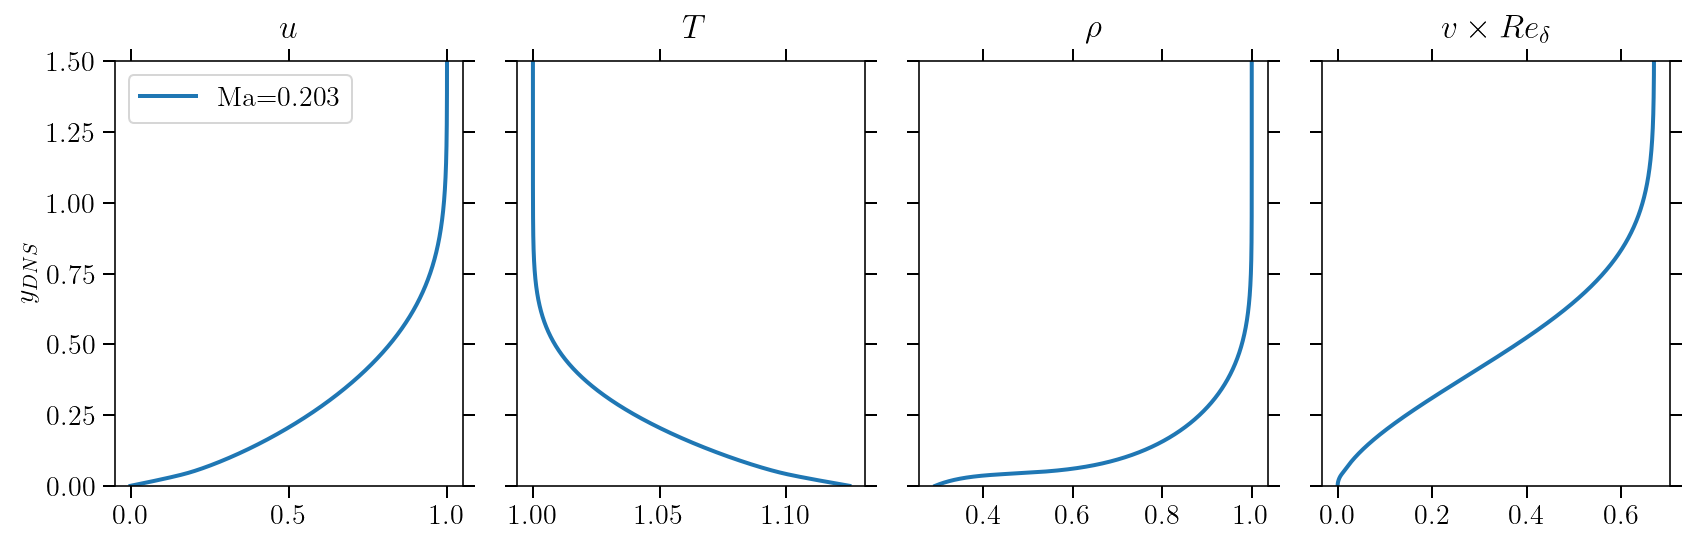

In [5]:
# Input parameters of BL_PR:
# 1) Free-stream Eckert number (Mach number will be calculated)
# 2) Free-stream reduced pressure (p_r = p_inf/p_c)
# 3) Free-stream reduced temperature (T_r = T_inf/T_c)
# 4) Cv/R - ratio
# 5) Viscosity law: 'JST' (JossiStielThodos), 'Chung' or 'Constant'
# 6) Prandtl number: if 'Chung', then it's newly calculated and overwritten, 
#                    if other viscosity laws, then it is kept.
# 7) Wall boundary condition: Tw_Tinf='None' for adiabatic or Tw_Tinf (Tw/Tinf) = ... for isothermal

pr = BL_PR(Ec=0.01,Pred=1.084,Tred=0.9207,CvR=9/2,visc='Chung',Pr=1.0,Tw_Tinf=1.125)
pr.extendProfileToLargerYforDNS(ymax=40)
pr.writeToFile()
pr.showParameters()

fig, ax = plt.subplots(1,4, figsize=(12,4), sharey=True)
pr.plot(ax,label='Ma=%.3f'%pr.Ma)
plt.tight_layout()